<a href="https://colab.research.google.com/github/SiMori92/MarketOpen30-DL/blob/main/v2_Step2_Processing_and_prepare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content

### Pre 1: Load libraries

### 1. Load data & normalise
  1. Load Data & normalise the data
  2. Inspection after processing

### 2. Back-test on Assumption
  H1: probabilities of either (1) 30-minutes return is positive or (2) high - open price > [1] %  > 60%
  - Summary stat
  - Inference

### (phase 2) 3. Features engineering
  1. Market Sentiment
    - Load data and processing
    - calculate market sentiment score

### 4. Prepare the Training dataset
  1. Trim down data set
  2. drop the missing value rows?
  3. (phase 2) combine with market sentiment
  4. data segmentation


## Pre 1: Load libraries

In [1]:
# import library

import pandas as pd
import numpy as np
from datetime import datetime
import uuid

## 1. Load data & normalise


In [3]:
import pandas as pd
import numpy as np

# Load the CSV data
def load_data(csv_file):
    df = pd.read_csv(csv_file, parse_dates=['Date'])
    df.sort_values('Date', inplace=True)  # Ensure data is sorted by date
    return df

# Calculate the new columns based on provided formulas
def calculate_metrics(df):
    # Initialize new columns with NaN
    new_columns = [
        'T-1 Price change',
        'T-1 high-low spread',
        'T-1 volume change',
        'T-1 volume compared to last 5 trading days average',
        'Pre-market price change',
        'Pre-market high-low spread',
        'Pre-market volume change',
        'Pre-market volume compared to last 5 trading days average',
        'Market Open compared to Price 1000',
        'Market Open compared to High price 0930 - 1000'
    ]

    for col in new_columns:
        df[col] = np.nan

    # T-1 Price change: (T-1 Close Price / last trading date T-1 Close Price) - 1
    df['T-1 Price change'] = df['T-1 Close Price'].pct_change()

    # T-1 high-low spread: (T-1 High Price / T-1 Low Price) - 1
    df['T-1 high-low spread'] = (df['T-1 High Price'] / df['T-1 Low Price']) - 1

    # T-1 volume change: (T-1 Volume / last trading date T-1 Volume) - 1
    df['T-1 volume change'] = df['T-1 Volume'].pct_change()

    # T-1 volume compared to last 5 trading days average
    df['T-1 volume compared to last 5 trading days average'] = (
        df['T-1 Volume'] / df['T-1 Volume'].rolling(window=5, min_periods=1).mean()
    )

    # Pre-market price change: (Pre-market Close Price / Pre-market Open Price) - 1
    df['Pre-market price change'] = (
        df['Pre-market/ Futures Close Price'] / df['Pre-market/ Futures Open Price'] - 1
    ).where(df['Pre-market/ Futures Open Price'].notna() & (df['Pre-market/ Futures Open Price'] != 0))

    # Pre-market high-low spread: (Pre-market High Price / Pre-market Low Price) - 1
    df['Pre-market high-low spread'] = (
        df['Pre-market/ Futures High Price'] / df['Pre-market/ Futures Low Price'] - 1
    ).where(df['Pre-market/ Futures Low Price'].notna() & (df['Pre-market/ Futures Low Price'] != 0))

    # Pre-market volume change: (Pre-market volume / last trading date Pre-market volume)
    df['Pre-market volume change'] = df['Pre-market/ Futures Volume'].pct_change()

    # Pre-market volume compared to last 5 trading days average
    df['Pre-market volume compared to last 5 trading days average'] = (
        df['Pre-market/ Futures Volume'] /
        df['Pre-market/ Futures Volume'].rolling(window=5, min_periods=1).mean()
    )

    # Market Open compared to Price 1000: (Price at 10:00 / Price at market open) - 1
    df['Market Open compared to Price 1000'] = (
        df['Price at 10:00'] / df['Price at market open'] - 1
    ).where(df['Price at market open'].notna() & (df['Price at market open'] != 0))

    # Market Open compared to High price 0930 - 1000
    # Calculate the maximum high price from 09:30 to 10:00
    high_price_columns = [
        'High Price 0930-0931', 'High Price 0931-0935', 'High Price 0936-0940',
        'High Price 0941-0945', 'High Price 0946-0950', 'High Price 0951-0955',
        'High Price 0956-1000'
    ]
    df['High price 0930 - 1000'] = df[high_price_columns].max(axis=1)
    df['Market Open compared to High price 0930 - 1000'] = (
        df['High price 0930 - 1000'] / df['Price at market open'] - 1
    ).where(df['Price at market open'].notna() & (df['Price at market open'] != 0))

    # Convert percentages to readable format (multiply by 100)
    percentage_columns = [
        'T-1 Price change', 'T-1 high-low spread', 'T-1 volume change',
        'T-1 volume compared to last 5 trading days average',
        'Pre-market price change', 'Pre-market high-low spread',
        'Pre-market volume change', 'Pre-market volume compared to last 5 trading days average',
        'Market Open compared to Price 1000', 'Market Open compared to High price 0930 - 1000'
    ]
    df[percentage_columns] = df[percentage_columns] * 100

    return df

# Save the updated dataframe to a new CSV
def save_data(df, output_file):
    df.to_csv(output_file, index=False)

# Main execution
if __name__ == "__main__":
    input_file = "SOXL_finance_data_2017-01-01_to_2025-06-20 .csv"
    output_file = "processed_stock_data_SOXL_finance_data_2017-01-01_to_2025-06-20.csv"

    # Load and process data
    df = load_data(input_file)
    df = calculate_metrics(df)
    save_data(df, output_file)

    print(f"Processed data saved to {output_file}")

Processed data saved to processed_stock_data_SOXL_finance_data_2017-01-01_to_2025-06-20.csv


/tmp/ipython-input-3-668145893.py:30: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['T-1 Price change'] = df['T-1 Close Price'].pct_change()
/tmp/ipython-input-3-668145893.py:36: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['T-1 volume change'] = df['T-1 Volume'].pct_change()
/tmp/ipython-input-3-668145893.py:54: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Pre-market volume change'] = df

### Inspection after processing



Summary Statistics for Newly Calculated Columns:
       T-1 Price change  T-1 high-low spread  T-1 volume change  \
count       2150.000000          2100.000000        2150.000000   
mean           0.282175             7.133260           7.566094   
std            6.284071             4.618793          54.279419   
min          -38.592980             1.349728         -74.964291   
25%           -2.814757             4.207358         -19.633753   
50%            0.304034             6.047007          -0.946441   
75%            3.694087             8.706589          22.964463   
max           54.787879            59.101942        1567.348952   

       T-1 volume compared to last 5 trading days average  \
count                                        2100.000000    
mean                                          100.901085    
std                                            27.700515    
min                                            37.418091    
25%                                       

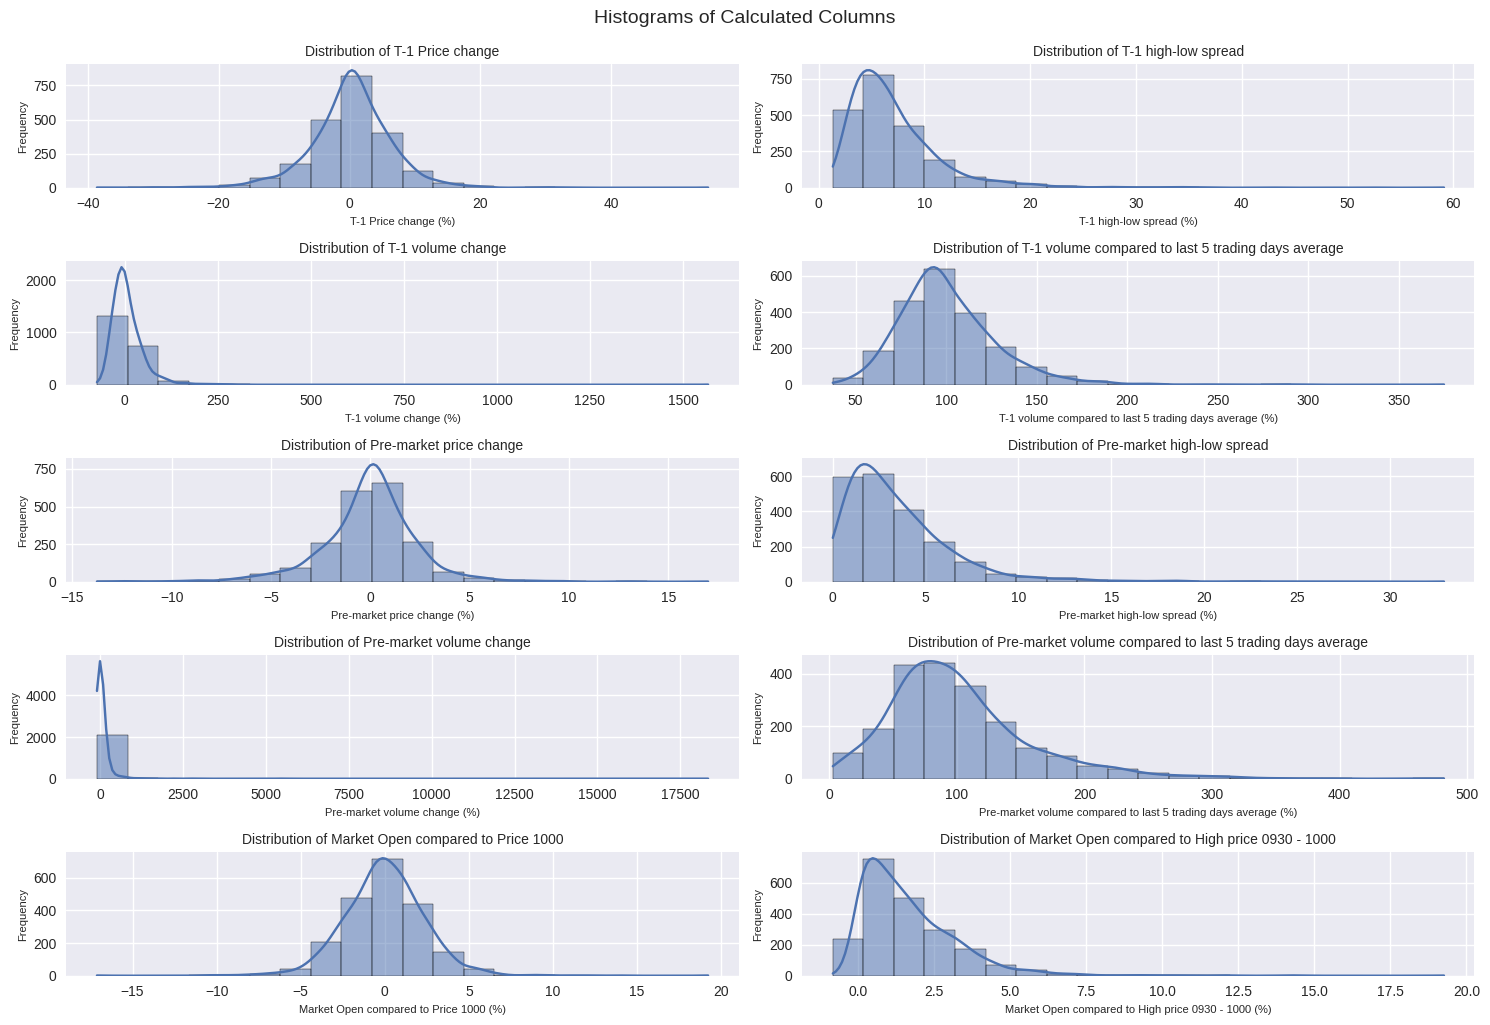

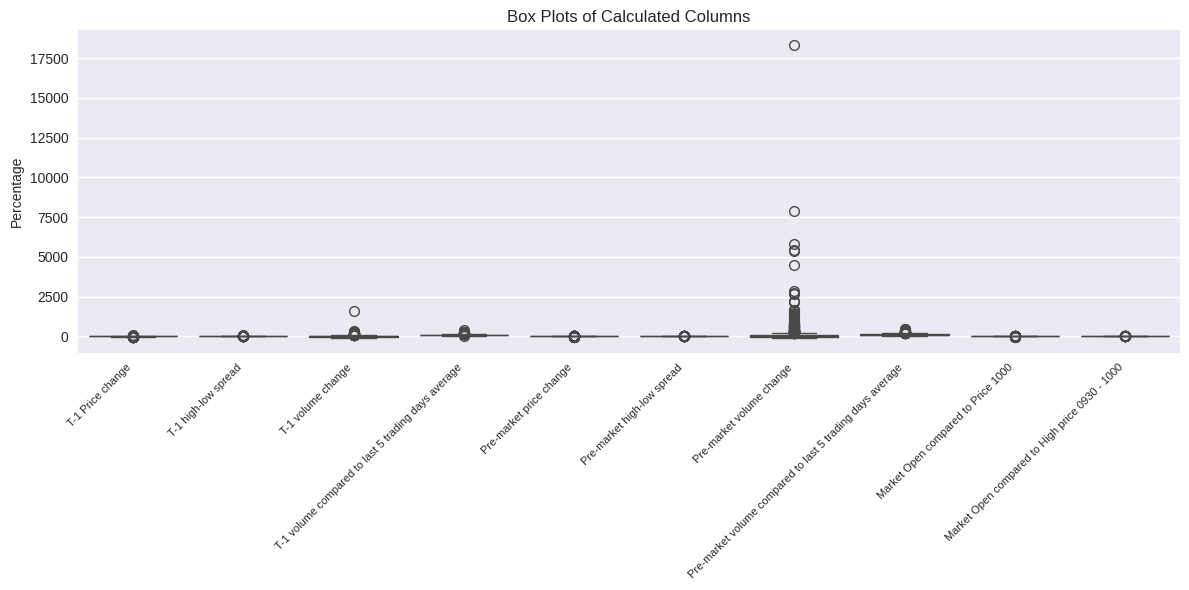

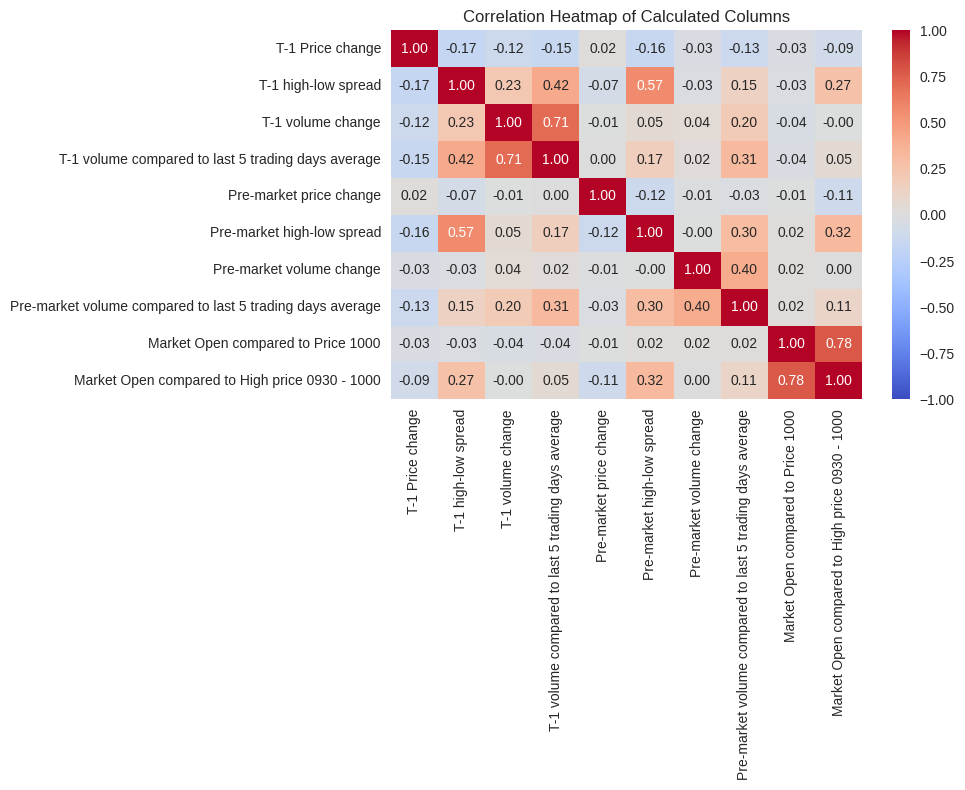

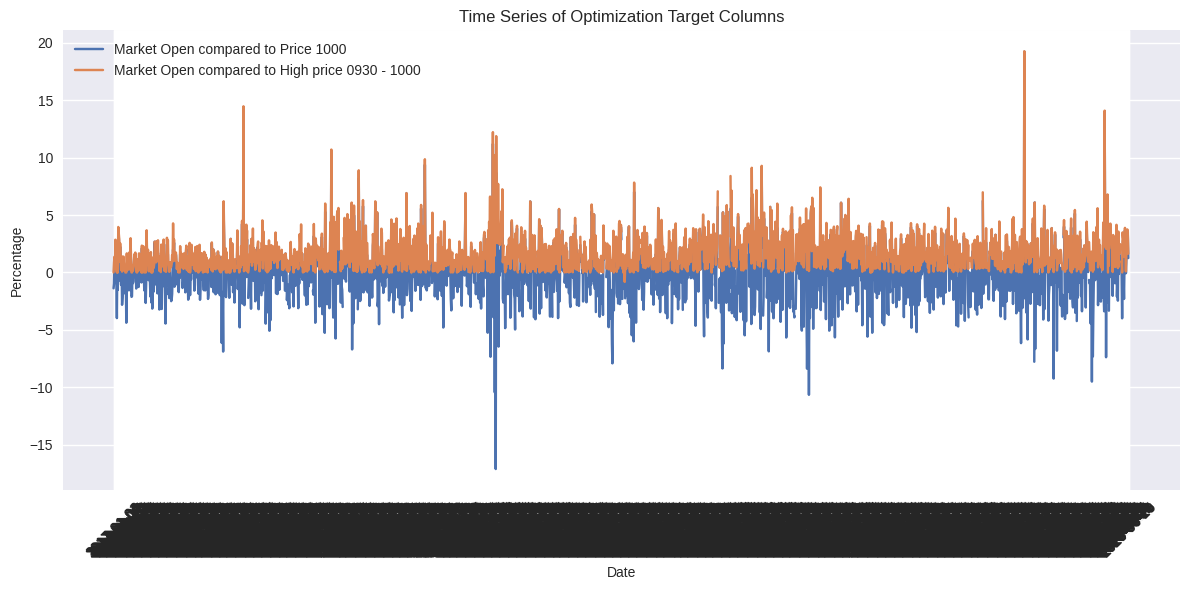

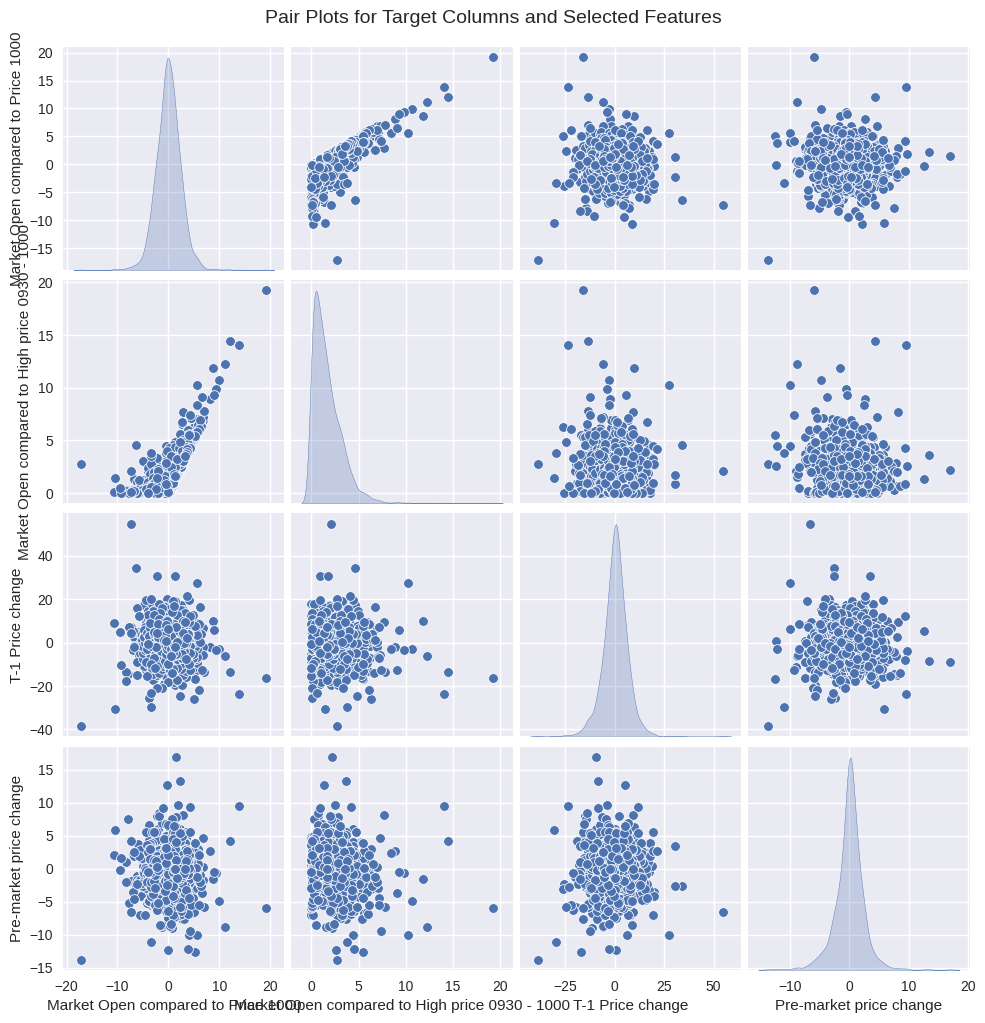

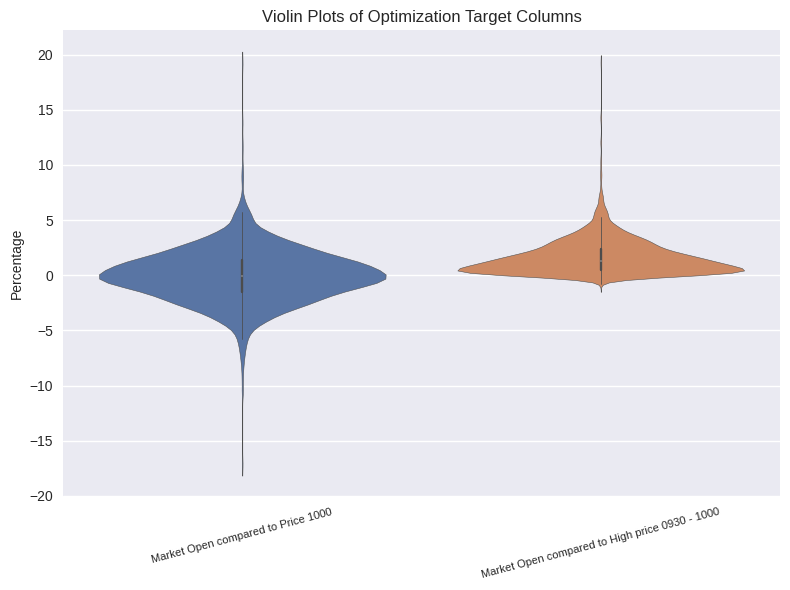


All plots displayed.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set plot style for better visualization
plt.style.use('seaborn-v0_8')  # Use a valid Matplotlib style
sns.set_palette("deep")

# Load the processed CSV data
def load_data(csv_file):
    df = pd.read_csv(csv_file)
    return df

# Inspect and visualize the newly calculated columns
def inspect_metrics(df):
    # Define the new columns to inspect
    new_columns = [
        'T-1 Price change',
        'T-1 high-low spread',
        'T-1 volume change',
        'T-1 volume compared to last 5 trading days average',
        'Pre-market price change',
        'Pre-market high-low spread',
        'Pre-market volume change',
        'Pre-market volume compared to last 5 trading days average',
        'Market Open compared to Price 1000',
        'Market Open compared to High price 0930 - 1000'
    ]

    # Summary statistics
    print("Summary Statistics for Newly Calculated Columns:")
    print(df[new_columns].describe())

    # Check for missing values
    print("\nMissing Values in Newly Calculated Columns:")
    print(df[new_columns].isna().sum())

    # Correlation matrix
    print("\nCorrelation Matrix for Newly Calculated Columns:")
    corr_matrix = df[new_columns].corr()
    print(corr_matrix)

    # Detailed analysis for optimization target columns
    target_columns = [
        'Market Open compared to Price 1000',
        'Market Open compared to High price 0930 - 1000'
    ]

    print("\nDetailed Distribution Analysis for Optimization Targets:")
    for col in target_columns:
        print(f"\n--- {col} ---")
        # Skewness and Kurtosis
        print(f"Skewness: {stats.skew(df[col].dropna()):.4f}")
        print(f"Kurtosis: {stats.kurtosis(df[col].dropna()):.4f}")
        # Normality test (Shapiro-Wilk)
        stat, p_value = stats.shapiro(df[col].dropna())
        print(f"Shapiro-Wilk Test: Statistic={stat:.4f}, p-value={p_value:.4f}")
        # Outlier detection using IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))][col]
        print(f"Number of Outliers (IQR method): {len(outliers)}")

    # Visualizations for all calculated columns
    # 1. Histograms for all new columns
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(new_columns, 1):
        plt.subplot(5, 2, i)
        sns.histplot(df[col].dropna(), kde=True, bins=20)
        plt.title(f'Distribution of {col}', fontsize=10)
        plt.xlabel(f'{col} (%)', fontsize=8)
        plt.ylabel('Frequency', fontsize=8)
        plt.tight_layout()
    plt.suptitle('Histograms of Calculated Columns', fontsize=14, y=1.02)
    plt.show()

    # 2. Box plots for all new columns
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[new_columns])
    plt.title('Box Plots of Calculated Columns', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.ylabel('Percentage', fontsize=10)
    plt.tight_layout()
    plt.show()

    # 3. Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation Heatmap of Calculated Columns', fontsize=12)
    plt.tight_layout()
    plt.show()

    # 4. Time series plots for target columns
    plt.figure(figsize=(12, 6))
    for col in target_columns:
        plt.plot(df['Date'], df[col], label=col)
    plt.title('Time Series of Optimization Target Columns', fontsize=12)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Percentage', fontsize=10)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 5. Pair plots for target columns vs. others (limited to avoid clutter)
    pair_columns = target_columns + ['T-1 Price change', 'Pre-market price change']
    sns.pairplot(df[pair_columns].dropna(), diag_kind='kde')
    plt.suptitle('Pair Plots for Target Columns and Selected Features', fontsize=14, y=1.02)
    plt.show()

    # 6. Violin plots for target columns
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df[target_columns])
    plt.title('Violin Plots of Optimization Target Columns', fontsize=12)
    plt.xticks(rotation=15, fontsize=8)
    plt.ylabel('Percentage', fontsize=10)
    plt.tight_layout()
    plt.show()

    print("\nAll plots displayed.")

# Main execution
if __name__ == "__main__":
    input_file = "processed_stock_data_SOXL_finance_data_2017-01-01_to_2025-06-20.csv"

    # Load and inspect data
    df = load_data(input_file)
    inspect_metrics(df)

## 2. Back-test on Assumption

H1: probabilities of either (1) 30-minutes return is positive or (2) high - open price > [1] % > 60%

In [7]:
import pandas as pd

# Reading the CSV file
df = pd.read_csv('processed_stock_data_SOXL_finance_data_2017-01-01_to_2025-06-20.csv')

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract year and month for grouping
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month_name()

# Extracting the relevant columns
market_open_to_1000 = df['Market Open compared to Price 1000']
market_open_to_high = df['Market Open compared to High price 0930 - 1000']

# Total number of records
total_records = len(df)

# Calculating counts and probabilities for overall data
results = {
    'Metric': [],
    'Count': [],
    'Probability (%)': []
}

# 1. Market Open compared to Price 1000 > 0
count_1 = sum(market_open_to_1000 > 0)
results['Metric'].append('Market Open > Price 1000')
results['Count'].append(count_1)
results['Probability (%)'].append((count_1 / total_records) * 100)

# 2. Market Open compared to High price 0930 - 1000 > 1
count_2 = sum(market_open_to_high > 1)
results['Metric'].append('Market Open > High price 0930-1000 by 1%')
results['Count'].append(count_2)
results['Probability (%)'].append((count_2 / total_records) * 100)

# 3. Market Open compared to High price 0930 - 1000 > 1.5
count_3 = sum(market_open_to_high > 1.5)
results['Metric'].append('Market Open > High price 0930-1000 by 1.5%')
results['Count'].append(count_3)
results['Probability (%)'].append((count_3 / total_records) * 100)

# 4. Market Open compared to High price 0930 - 1000 > 2
count_4 = sum(market_open_to_high > 2)
results['Metric'].append('Market Open > High price 0930-1000 by 2%')
results['Count'].append(count_4)
results['Probability (%)'].append((count_4 / total_records) * 100)

# 5. Market Open compared to High price 0930 - 1000 > 2.5
count_5 = sum(market_open_to_high > 2.5)
results['Metric'].append('Market Open > High price 0930-1000 by 2.5%')
results['Count'].append(count_5)
results['Probability (%)'].append((count_5 / total_records) * 100)

# 6. Market Open compared to High price 0930 - 1000 > 3
count_6 = sum(market_open_to_high > 3)
results['Metric'].append('Market Open > High price 0930-1000 by 3%')
results['Count'].append(count_6)
results['Probability (%)'].append((count_6 / total_records) * 100)

# 7. 1 OR 2
count_7 = sum((market_open_to_1000 > 0) | (market_open_to_high > 1))
results['Metric'].append('Market Open > Price 1000 OR > High price 0930-1000 by 1%')
results['Count'].append(count_7)
results['Probability (%)'].append((count_7 / total_records) * 100)

# 8. 1 OR 3
count_8 = sum((market_open_to_1000 > 0) | (market_open_to_high > 1.5))
results['Metric'].append('Market Open > Price 1000 OR > High price 0930-1000 by 1.5%')
results['Count'].append(count_8)
results['Probability (%)'].append((count_8 / total_records) * 100)

# 9. 1 OR 4
count_9 = sum((market_open_to_1000 > 0) | (market_open_to_high > 2))
results['Metric'].append('Market Open > Price 1000 OR > High price 0930-1000 by 2%')
results['Count'].append(count_9)
results['Probability (%)'].append((count_9 / total_records) * 100)

# 10. 1 OR 5
count_10 = sum((market_open_to_1000 > 0) | (market_open_to_high > 2.5))
results['Metric'].append('Market Open > Price 1000 OR > High price 0930-1000 by 2.5%')
results['Count'].append(count_10)
results['Probability (%)'].append((count_10 / total_records) * 100)

# 11. 1 OR 6
count_11 = sum((market_open_to_1000 > 0) | (market_open_to_high > 3))
results['Metric'].append('Market Open > Price 1000 OR > High price 0930-1000 by 3%')
results['Count'].append(count_11)
results['Probability (%)'].append((count_11 / total_records) * 100)

# Creating a DataFrame for overall results
results_df = pd.DataFrame(results)

# Printing the overall results
print(f"Total records: {total_records}")
print("\nOverall Counts and Probabilities:")
print(results_df.to_string(index=False))

# Saving overall results to a CSV file
results_df.to_csv('analysis_results_overall.csv', index=False)

# Breakdown by Year
years = range(2017, 2026)
year_results = {'Metric': results['Metric']}
for year in years:
    year_df = df[df['Year'] == year]
    if len(year_df) == 0:
        continue
    year_total = len(year_df)
    year_counts = []

    # Calculate counts for each metric
    year_counts.append(sum(year_df['Market Open compared to Price 1000'] > 0))
    year_counts.append(sum(year_df['Market Open compared to High price 0930 - 1000'] > 1))
    year_counts.append(sum(year_df['Market Open compared to High price 0930 - 1000'] > 1.5))
    year_counts.append(sum(year_df['Market Open compared to High price 0930 - 1000'] > 2))
    year_counts.append(sum(year_df['Market Open compared to High price 0930 - 1000'] > 2.5))
    year_counts.append(sum(year_df['Market Open compared to High price 0930 - 1000'] > 3))
    year_counts.append(sum((year_df['Market Open compared to Price 1000'] > 0) | (year_df['Market Open compared to High price 0930 - 1000'] > 1)))
    year_counts.append(sum((year_df['Market Open compared to Price 1000'] > 0) | (year_df['Market Open compared to High price 0930 - 1000'] > 1.5)))
    year_counts.append(sum((year_df['Market Open compared to Price 1000'] > 0) | (year_df['Market Open compared to High price 0930 - 1000'] > 2)))
    year_counts.append(sum((year_df['Market Open compared to Price 1000'] > 0) | (year_df['Market Open compared to High price 0930 - 1000'] > 2.5)))
    year_counts.append(sum((year_df['Market Open compared to Price 1000'] > 0) | (year_df['Market Open compared to High price 0930 - 1000'] > 3)))

    # Convert counts to probabilities
    year_probs = [(count / year_total) * 100 for count in year_counts]
    year_results[str(year)] = year_probs

# Creating a DataFrame for yearly results
year_results_df = pd.DataFrame(year_results)

# Printing the yearly breakdown
print("\nCounts and Probabilities by Year (%):")
print(year_results_df.to_string(index=False))

# Saving yearly results to a CSV file
year_results_df.to_csv('analysis_results_by_year.csv', index=False)

# Breakdown by Month
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']
month_results = {'Metric': results['Metric']}
for month in months:
    month_df = df[df['Month'] == month]
    if len(month_df) == 0:
        continue
    month_total = len(month_df)
    month_counts = []

    # Calculate counts for each metric
    month_counts.append(sum(month_df['Market Open compared to Price 1000'] > 0))
    month_counts.append(sum(month_df['Market Open compared to High price 0930 - 1000'] > 1))
    month_counts.append(sum(month_df['Market Open compared to High price 0930 - 1000'] > 1.5))
    month_counts.append(sum(month_df['Market Open compared to High price 0930 - 1000'] > 2))
    month_counts.append(sum(month_df['Market Open compared to High price 0930 - 1000'] > 2.5))
    month_counts.append(sum(month_df['Market Open compared to High price 0930 - 1000'] > 3))
    month_counts.append(sum((month_df['Market Open compared to Price 1000'] > 0) | (month_df['Market Open compared to High price 0930 - 1000'] > 1)))
    month_counts.append(sum((month_df['Market Open compared to Price 1000'] > 0) | (month_df['Market Open compared to High price 0930 - 1000'] > 1.5)))
    month_counts.append(sum((month_df['Market Open compared to Price 1000'] > 0) | (month_df['Market Open compared to High price 0930 - 1000'] > 2)))
    month_counts.append(sum((month_df['Market Open compared to Price 1000'] > 0) | (month_df['Market Open compared to High price 0930 - 1000'] > 2.5)))
    month_counts.append(sum((month_df['Market Open compared to Price 1000'] > 0) | (month_df['Market Open compared to High price 0930 - 1000'] > 3)))

    # Convert counts to probabilities
    month_probs = [(count / month_total) * 100 for count in month_counts]
    month_results[month] = month_probs

# Creating a DataFrame for monthly results
month_results_df = pd.DataFrame(month_results)

# Printing the monthly breakdown
print("\nCounts and Probabilities by Month (%):")
print(month_results_df.to_string(index=False))

# Saving monthly results to a CSV file
month_results_df.to_csv('analysis_results_by_month.csv', index=False)

Total records: 2151

Overall Counts and Probabilities:
                                                    Metric  Count  Probability (%)
                                  Market Open > Price 1000   1035        48.117155
                  Market Open > High price 0930-1000 by 1%   1224        56.903766
                Market Open > High price 0930-1000 by 1.5%    923        42.910274
                  Market Open > High price 0930-1000 by 2%    683        31.752673
                Market Open > High price 0930-1000 by 2.5%    504        23.430962
                  Market Open > High price 0930-1000 by 3%    358        16.643422
  Market Open > Price 1000 OR > High price 0930-1000 by 1%   1343        62.436076
Market Open > Price 1000 OR > High price 0930-1000 by 1.5%   1187        55.183636
  Market Open > Price 1000 OR > High price 0930-1000 by 2%   1106        51.417945
Market Open > Price 1000 OR > High price 0930-1000 by 2.5%   1074        49.930265
  Market Open > Price 1000 OR > 

Statistical inference

In [11]:
# OR high - open price > [1] %

import pandas as pd
import numpy as np
from scipy.stats import binomtest
from statsmodels.stats.proportion import proportion_confint
import pymc as pm
import arviz as az

# Reading the CSV file
df = pd.read_csv('processed_stock_data_SOXL_finance_data_2017-01-01_to_2025-06-20.csv')

# Extract relevant columns
market_open_to_1000 = df['Market Open compared to Price 1000']
market_open_to_high = df['Market Open compared to High price 0930 - 1000']

# Define the condition for the hypothesis
condition = (market_open_to_1000 > 0) | (market_open_to_high > 1)
n_total = len(df)
n_success = sum(condition)
observed_prob = n_success / n_total

# Hypothesis parameters
hypothesized_prob = 0.6  # H1: probability > 60%

# 1. Binomial Test
# H0: p <= 0.6, H1: p > 0.6 (one-sided test)
binom_result = binomtest(n_success, n_total, hypothesized_prob, alternative='greater')
binom_p_value = binom_result.pvalue

# 2. Bootstrap Confidence Interval
n_bootstraps = 10000
bootstrap_probs = []
np.random.seed(42)
for _ in range(n_bootstraps):
    sample = np.random.choice(condition, size=n_total, replace=True)
    bootstrap_probs.append(np.mean(sample))
bootstrap_ci = np.percentile(bootstrap_probs, [2.5, 97.5])

# 3. Bayesian Inference
with pm.Model() as model:
    p = pm.Beta('p', alpha=1, beta=1)  # Uniform prior
    obs = pm.Bernoulli('obs', p=p, observed=condition)
    trace = pm.sample(1000, tune=1000, return_inferencedata=True, random_seed=42)
bayesian_prob = trace.posterior['p'].mean().item()
# Extract HDI directly from az.hdi
bayesian_credible_interval = az.hdi(trace.posterior['p'], hdi_prob=0.95)['p'].values

# Summarize results
summary = {
    'Metric': [
        'Observed Probability',
        'Binomial Test p-value',
        'Bootstrap 95% CI Lower',
        'Bootstrap 95% CI Upper',
        'Bayesian Posterior Mean',
        'Bayesian 95% Credible Interval Lower',
        'Bayesian 95% Credible Interval Upper'
    ],
    'Value': [
        observed_prob,
        binom_p_value,
        bootstrap_ci[0],
        bootstrap_ci[1],
        bayesian_prob,
        bayesian_credible_interval[0],
        bayesian_credible_interval[1]
    ]
}
summary_df = pd.DataFrame(summary)

# Print summary
print(f"Total observations: {n_total}")
print(f"Successes (condition met): {n_success}")
print("\nStatistical Inference Summary:")
print(summary_df.to_string(index=False))

# Save summary to CSV
summary_df.to_csv('hypothesis_test_summary.csv', index=False)

# Interpretation
print("\nInterpretation:")
if binom_p_value < 0.05:
    print("Binomial Test: Reject H0 (p <= 0.6) in favor of H1 (p > 0.6) at 5% significance level.")
else:
    print("Binomial Test: Fail to reject H0 (p <= 0.6) at 5% significance level.")
if bootstrap_ci[0] > 0.6:
    print("Bootstrap CI: The 95% CI lies entirely above 0.6, supporting H1.")
else:
    print("Bootstrap CI: The 95% CI includes values <= 0.6, not strongly supporting H1.")
if bayesian_credible_interval[0] > 0.6:
    print("Bayesian Inference: The 95% credible interval lies above 0.6, supporting H1.")
else:
    print("Bayesian Inference: The 95% credible interval includes values <= 0.6, not strongly supporting H1.")

Output()

Total observations: 2151
Successes (condition met): 1343

Statistical Inference Summary:
                              Metric    Value
                Observed Probability 0.624361
               Binomial Test p-value 0.010986
              Bootstrap 95% CI Lower 0.603440
              Bootstrap 95% CI Upper 0.644816
             Bayesian Posterior Mean 0.624643
Bayesian 95% Credible Interval Lower 0.602529
Bayesian 95% Credible Interval Upper 0.644127

Interpretation:
Binomial Test: Reject H0 (p <= 0.6) in favor of H1 (p > 0.6) at 5% significance level.
Bootstrap CI: The 95% CI lies entirely above 0.6, supporting H1.
Bayesian Inference: The 95% credible interval lies above 0.6, supporting H1.


In [13]:
# OR high - open price > [1.5] %

import pandas as pd
import numpy as np
from scipy.stats import binomtest
from statsmodels.stats.proportion import proportion_confint
import pymc as pm
import arviz as az

# Reading the CSV file
df = pd.read_csv('processed_stock_data_SOXL_finance_data_2017-01-01_to_2025-06-20.csv')

# Extract relevant columns
market_open_to_1000 = df['Market Open compared to Price 1000']
market_open_to_high = df['Market Open compared to High price 0930 - 1000']

# Define the condition for the hypothesis
condition = (market_open_to_1000 > 0) | (market_open_to_high > 1.5)
n_total = len(df)
n_success = sum(condition)
observed_prob = n_success / n_total

# Hypothesis parameters
hypothesized_prob = 0.6  # H1: probability > 60%

# 1. Binomial Test
# H0: p <= 0.6, H1: p > 0.6 (one-sided test)
binom_result = binomtest(n_success, n_total, hypothesized_prob, alternative='greater')
binom_p_value = binom_result.pvalue

# 2. Bootstrap Confidence Interval
n_bootstraps = 10000
bootstrap_probs = []
np.random.seed(42)
for _ in range(n_bootstraps):
    sample = np.random.choice(condition, size=n_total, replace=True)
    bootstrap_probs.append(np.mean(sample))
bootstrap_ci = np.percentile(bootstrap_probs, [2.5, 97.5])

# 3. Bayesian Inference
with pm.Model() as model:
    p = pm.Beta('p', alpha=1, beta=1)  # Uniform prior
    obs = pm.Bernoulli('obs', p=p, observed=condition)
    trace = pm.sample(1000, tune=1000, return_inferencedata=True, random_seed=42)
bayesian_prob = trace.posterior['p'].mean().item()
# Extract HDI directly from az.hdi
bayesian_credible_interval = az.hdi(trace.posterior['p'], hdi_prob=0.95)['p'].values

# Summarize results
summary = {
    'Metric': [
        'Observed Probability',
        'Binomial Test p-value',
        'Bootstrap 95% CI Lower',
        'Bootstrap 95% CI Upper',
        'Bayesian Posterior Mean',
        'Bayesian 95% Credible Interval Lower',
        'Bayesian 95% Credible Interval Upper'
    ],
    'Value': [
        observed_prob,
        binom_p_value,
        bootstrap_ci[0],
        bootstrap_ci[1],
        bayesian_prob,
        bayesian_credible_interval[0],
        bayesian_credible_interval[1]
    ]
}
summary_df = pd.DataFrame(summary)

# Print summary
print(f"Total observations: {n_total}")
print(f"Successes (condition met): {n_success}")
print("\nStatistical Inference Summary:")
print(summary_df.to_string(index=False))

# Save summary to CSV
summary_df.to_csv('hypothesis_test_summary.csv', index=False)

# Interpretation
print("\nInterpretation:")
if binom_p_value < 0.05:
    print("Binomial Test: Reject H0 (p <= 0.6) in favor of H1 (p > 0.6) at 5% significance level.")
else:
    print("Binomial Test: Fail to reject H0 (p <= 0.6) at 5% significance level.")
if bootstrap_ci[0] > 0.6:
    print("Bootstrap CI: The 95% CI lies entirely above 0.6, supporting H1.")
else:
    print("Bootstrap CI: The 95% CI includes values <= 0.6, not strongly supporting H1.")
if bayesian_credible_interval[0] > 0.6:
    print("Bayesian Inference: The 95% credible interval lies above 0.6, supporting H1.")
else:
    print("Bayesian Inference: The 95% credible interval includes values <= 0.6, not strongly supporting H1.")

Output()

Total observations: 2151
Successes (condition met): 1187

Statistical Inference Summary:
                              Metric    Value
                Observed Probability 0.551836
               Binomial Test p-value 0.999997
              Bootstrap 95% CI Lower 0.530916
              Bootstrap 95% CI Upper 0.572757
             Bayesian Posterior Mean 0.551520
Bayesian 95% Credible Interval Lower 0.531252
Bayesian 95% Credible Interval Upper 0.572731

Interpretation:
Binomial Test: Fail to reject H0 (p <= 0.6) at 5% significance level.
Bootstrap CI: The 95% CI includes values <= 0.6, not strongly supporting H1.
Bayesian Inference: The 95% credible interval includes values <= 0.6, not strongly supporting H1.


## 3. (phase 2)Feature enginnering

###2.1 Market Sentiment

Load Data and calculate the percentage changes

In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# Load the CSV files
vix_df = pd.read_csv('^VIX_data.csv')
vxx_df = pd.read_csv('VXX_finance_data_2017-01-01_to_2025-06-20.csv')

# Convert Date columns to datetime
vix_df['Date'] = pd.to_datetime(vix_df['Date'])
vxx_df['Date'] = pd.to_datetime(vxx_df['Date'])

# Function to get previous trading day's date
def get_previous_trading_day(date, df):
    date = pd.to_datetime(date)
    prev_day = date - timedelta(days=1)
    while prev_day not in df['Date'].values:
        prev_day -= timedelta(days=1)
        if prev_day < df['Date'].min():
            return None
    return prev_day

# Initialize result list to collect rows
result_rows = []

# Process each date in vxx_df
for date in vxx_df['Date']:
    # Get previous trading day
    prev_trading_day = get_previous_trading_day(date, vix_df)
    if prev_trading_day is None:
        continue

    # Get T-1 Close Price from vix_df
    t1_close = vix_df[vix_df['Date'] == prev_trading_day]['Close Price'].iloc[0] if prev_trading_day in vix_df['Date'].values else float('nan')

    # Get current row from vxx_df
    current_row = vxx_df[vxx_df['Date'] == date].iloc[0]

    # Calculate T-1 Price Change
    prev_vxx_row = vxx_df[vxx_df['Date'] < date].sort_values('Date').iloc[-1] if not vxx_df[vxx_df['Date'] < date].empty else None
    t1_price_change = (current_row['T-1 Close Price'] / prev_vxx_row['T-1 Close Price'] - 1) * 100 if prev_vxx_row is not None else float('nan')

    # Calculate T-1 High-Low Spread
    t1_high_low_spread = (current_row['T-1 High Price'] / current_row['T-1 Low Price'] - 1) * 100 if current_row['T-1 Low Price'] != 0 else float('nan')

    # Calculate Pre-market Price Change
    pre_market_price_change = (current_row['Pre-market/ Futures Close Price'] / current_row['Pre-market/ Futures Open Price'] - 1) * 100 if current_row['Pre-market/ Futures Open Price'] != 0 else float('nan')

    # Calculate Pre-market High-Low Spread
    pre_market_high_low_spread = (current_row['Pre-market/ Futures High Price'] / current_row['Pre-market/ Futures Low Price'] - 1) * 100 if current_row['Pre-market/ Futures Low Price'] != 0 else float('nan')

    # Append row to result list
    result_rows.append({
        'Date': date,
        'T-1 Close Price': t1_close,
        'T-1 Price Change': t1_price_change,
        'T-1 High-Low Spread': t1_high_low_spread,
        'Pre-market Price Change': pre_market_price_change,
        'Pre-market High-Low Spread': pre_market_high_low_spread
    })

# Create result DataFrame from list
result_df = pd.DataFrame(result_rows, columns=[
    'Date',
    'T-1 Close Price',
    'T-1 Price Change',
    'T-1 High-Low Spread',
    'Pre-market Price Change',
    'Pre-market High-Low Spread'
])

# Format percentages to 2 decimal places
result_df['T-1 Price Change'] = result_df['T-1 Price Change'].round(2)
result_df['T-1 High-Low Spread'] = result_df['T-1 High-Low Spread'].round(2)
result_df['Pre-market Price Change'] = result_df['Pre-market Price Change'].round(2)
result_df['Pre-market High-Low Spread'] = result_df['Pre-market High-Low Spread'].round(2)

# Save to CSV
result_df.to_csv('result_dataframe.csv', index=False)

Calculate the sentiment score

In [ ]:
import pandas as pd

# Load the CSV files
sentiment_df = pd.read_csv('result_dataframe.csv')

# Assuming df is the DataFrame with the required columns
# Columns: 'VIX_T1', 'VXX_PC_T1', 'VXX_HLS_T1', 'VXX_PC_PM', 'VXX_HLS_PM'

# Set weights for the percentage indicators
w1 = w2 = 0.17
w3 = w4 = 0.33

# Calculate the adjustment factor
sentiment_df['adjustment'] = (100 + (w1 * sentiment_df['T-1 Price Change'] +
                        w2 * sentiment_df['T-1 High-Low Spread'] +
                        w3 * sentiment_df['Pre-market Price Change'] +
                        w4 * sentiment_df['Pre-market High-Low Spread']))/100

# Compute market sentiment score
sentiment_df['market_sentiment'] = (sentiment_df['T-1 Close Price'] / 100) * sentiment_df['adjustment']

1. DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2150 entries, 0 to 2149
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        2150 non-null   object 
 1   T-1 Close Price             2150 non-null   float64
 2   T-1 Price Change            2048 non-null   float64
 3   T-1 High-Low Spread         2099 non-null   float64
 4   Pre-market Price Change     2099 non-null   float64
 5   Pre-market High-Low Spread  2099 non-null   float64
 6   adjustment                  2048 non-null   float64
 7   market_sentiment            2048 non-null   float64
dtypes: float64(7), object(1)
memory usage: 134.5+ KB
None

2. Shape of DataFrame: (2150, 8)

3. Summary Statistics:
              Date  T-1 Close Price  T-1 Price Change  T-1 High-Low Spread  \
count         2150      2150.000000       2048.000000          2099.000000   
unique        2150              

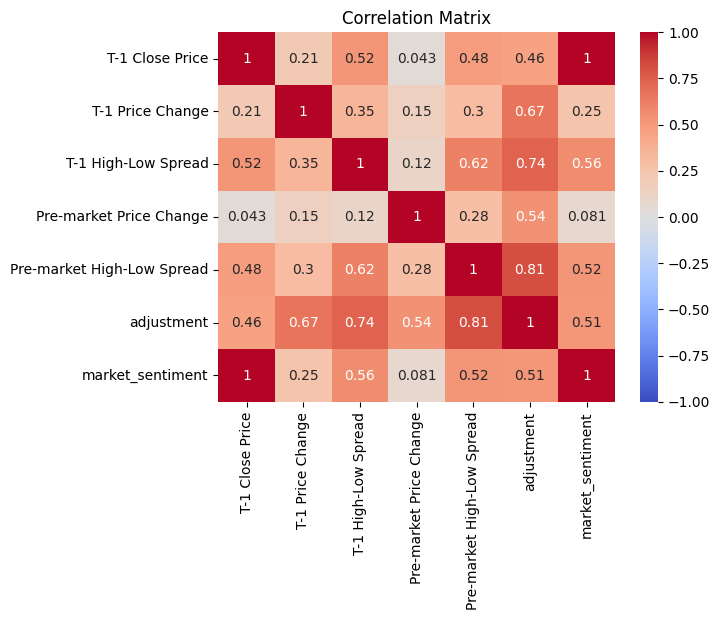


11. Sample Data:
         Date  T-1 Close Price  T-1 Price Change  T-1 High-Low Spread  \
0  2017-01-04            12.85             -7.10                 4.32   
1  2017-01-05            11.85             -5.15                 5.49   
2  2017-01-06            11.67             -0.36                 3.22   
3  2017-01-09            11.32             -1.21                 3.33   
4  2017-01-10            11.56             -0.41                 3.27   
5  2017-01-11            11.49             -0.64                 2.68   
6  2017-01-12            11.26             -2.10                 4.64   
7  2017-01-13            11.54             -0.19                 5.29   
8  2017-01-17            11.23              0.23                 2.55   
9  2017-01-18            11.87             -0.28                 2.49   

   Pre-market Price Change  Pre-market High-Low Spread  adjustment  \
0                    -0.55                        0.64    0.995571   
1                     0.89            

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume sentiment_df is your DataFrame
# Example: sentiment_df = pd.read_csv('sentiment_data.csv')

# 1. Basic Information
print("1. DataFrame Info:")
print(sentiment_df.info())  # Data types, non-null counts, memory usage
print("\n2. Shape of DataFrame:", sentiment_df.shape)  # Rows and columns

# 2. Summary Statistics
print("\n3. Summary Statistics:")
print(sentiment_df.describe(include='all'))  # Numerical and categorical stats

# 3. Missing Values
print("\n4. Missing Values:")
missing = sentiment_df.isnull().sum()
print(missing[missing > 0])  # Columns with missing values
print("Percentage of missing values:")
print((missing / len(sentiment_df) * 100).round(2))

# 4. Unique Values and Cardinality
print("\n5. Unique Values per Column:")
for col in sentiment_df.columns:
    print(f"{col}: {sentiment_df[col].nunique()} unique values")
    if sentiment_df[col].dtype == 'object':
        print(f"Sample values in {col}: {sentiment_df[col].head(3).tolist()}")

# 5. Target Variable Distribution (assuming 'sentiment' is the target)
print("\n6. Target Variable Distribution:")
if 'sentiment' in sentiment_df.columns:
    print(sentiment_df['sentiment'].value_counts(normalize=True) * 100)
    sns.countplot(x='sentiment', data=sentiment_df)
    plt.title('Sentiment Distribution')
    plt.show()
else:
    print("No 'sentiment' column found. Check target variable name.")

# 6. Check for Duplicates
print("\n7. Duplicate Rows:")
duplicates = sentiment_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    print("Sample duplicates:")
    print(sentiment_df[sentiment_df.duplicated()].head())

# 7. Text Length Analysis (assuming a text column, e.g., 'text')
if 'text' in sentiment_df.columns:
    print("\n8. Text Length Analysis:")
    sentiment_df['text_length'] = sentiment_df['text'].str.len()
    print(sentiment_df['text_length'].describe())
    sns.histplot(sentiment_df['text_length'], bins=50)
    plt.title('Text Length Distribution')
    plt.show()
    # Check for empty or very short texts
    short_texts = sentiment_df[sentiment_df['text_length'] < 5]
    if not short_texts.empty:
        print("Short texts (length < 5):")
        print(short_texts[['text', 'text_length']].head())

# 8. Outlier Detection for Numerical Columns
print("\n9. Outlier Detection for Numerical Columns:")
numerical_cols = sentiment_df.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    Q1 = sentiment_df[col].quantile(0.25)
    Q3 = sentiment_df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((sentiment_df[col] < (Q1 - 1.5 * IQR)) | (sentiment_df[col] > (Q3 + 1.5 * IQR))).sum()
    if outliers > 0:
        print(f"{col}: {outliers} outliers detected")

# 9. Correlation Analysis for Numerical Columns
if len(numerical_cols) > 1:
    print("\n10. Correlation Matrix:")
    corr = sentiment_df[numerical_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix')
    plt.show()

# 10. Sample Data Inspection
print("\n11. Sample Data:")
print(sentiment_df.head(10))  # First 10 rows for manual inspection

## 4. Prepare the Training dataset





 ### 4.1. Trim down data set

In [15]:
import pandas as pd

# Reading the CSV file
df = pd.read_csv('processed_stock_data_SOXL_finance_data_2017-01-01_to_2025-06-20.csv')

# Selecting the specified columns
columns_to_keep = [
    'Date',
    'T-1 Price change',
    'T-1 high-low spread',
    'T-1 volume change',
    'T-1 volume compared to last 5 trading days average',
    'Pre-market price change',
    'Pre-market high-low spread',
    'Pre-market volume change',
    'Pre-market volume compared to last 5 trading days average',
    'Market Open compared to Price 1000',
    'Market Open compared to High price 0930 - 1000'
]

# Creating a new DataFrame with only the selected columns
trimmed_df = df[columns_to_keep]



### 4.2 Remove missing data rows

In [19]:
# Removing the first row
trimmed_df = trimmed_df.iloc[1:]

# Removing rows with any missing values (null)
trimmed_df = trimmed_df.dropna()

# Saving the trimmed DataFrame to a new CSV file
trimmed_df.to_csv('trimmed_SOXL.csv', index=False)

# Calculating summary statistics for numerical columns
summary_stats = trimmed_df.describe()

# Printing the first few rows of the trimmed DataFrame
print("Trimmed DataFrame Head:")
print(trimmed_df.head())
print("\nSummary Statistics:")
print(summary_stats)

Trimmed DataFrame Head:
          Date  T-1 Price change  T-1 high-low spread  T-1 volume change  \
4   2017-01-09          2.405560             4.664438          36.406331   
5   2017-01-10          3.219071             3.483359          10.662790   
7   2017-01-12          0.946529             2.236798         -15.152333   
9   2017-01-17          1.891253             2.716866         -18.304755   
12  2017-01-20         -1.370321             3.605294         -26.250103   

    T-1 volume compared to last 5 trading days average  \
4                                          103.925390    
5                                          114.146763    
7                                           77.009824    
9                                           95.261645    
12                                          69.005865    

    Pre-market price change  Pre-market high-low spread  \
4                  0.000000                    0.000000   
5                 -0.387607                    0.389

### 4.3 (phase 2) combine with market sentiment

In [ ]:
import pandas as pd

# Assuming sentiment_df and cleaned_df are already loaded DataFrames
# Convert 'Date' column in sentiment_df to datetime
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

# Merge sentiment_df with cleaned_df using 'Date' as key
cleaned_df = cleaned_df.merge(
    sentiment_df[['Date', 'market_sentiment']],
    on='Date',
    how='left'
)

# Save the updated DataFrame
cleaned_df.to_csv('updated_cleaned_df.csv', index=False)

In [ ]:
cleaned_df

,Date,T-1 Price change,T-1 high-low spread,T-1 volume change,T-1 volume compared to last 5 trading days average,Pre-market price change at 08:00,Pre-market volume at 0800 compared to last 5 trading days average,Pre-market volume at 0800 compare to T-1 volume,Pre-market price change,Pre-market high-low spread,...,Volume 0955 change,Volume 0955 compare to Volume 0950,Volume 0955 compared to last 5 trading days average,Price 1000 compared to Price 0955,0955-1000 high-low spread,Volume 1000 change,Volume 1000 compare to Volume 0955,Volume 1000 compared to last 5 trading days average,Volume 0935 compared to last 5 trading days average,market_sentiment
0,2017-01-03,NaN,0.085866,NaN,1.000000,NaN,NaN,NaN,-0.010748,0.011189,...,NaN,0.259844,1.000000,0.008365,0.007467,NaN,0.493077,1.000000,1.000000,NaN
1,2017-01-04,0.001576,0.071287,0.191871,1.087538,NaN,NaN,NaN,0.000000,0.000000,...,0.801282,0.734603,0.889680,-0.000873,0.003315,1.352054,0.832000,1.149679,0.398615,0.127931
2,2017-01-05,0.009092,0.028051,-0.426299,0.713346,0.000000,1.000000,0.031557,0.000000,0.000000,...,4.652800,0.476409,2.022722,-0.000992,0.004969,1.155000,0.206534,1.197050,0.364950,0.119441
3,2017-01-06,-0.027552,0.050321,0.001641,0.769432,NaN,NaN,NaN,0.000166,0.001248,...,0.631637,0.425382,1.194706,0.005312,0.006572,0.517816,0.169316,0.684947,2.877210,0.117445
4,2017-01-09,0.024056,0.046644,0.364063,1.039254,NaN,NaN,NaN,0.000000,0.000000,...,0.715919,1.242911,0.880801,0.000501,0.003904,4.594855,1.086692,2.201713,0.465836,0.114097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146,2025-06-16,-0.076072,0.061492,0.663499,1.138670,0.012640,0.873789,0.041898,0.012640,0.038176,...,1.450462,0.965778,1.401938,-0.001637,0.009341,0.817166,0.784753,1.179386,1.097931,0.214794
2147,2025-06-17,0.092814,0.068783,-0.269581,0.880600,0.002775,0.816789,0.053979,-0.000463,0.036441,...,0.647365,0.881182,0.927823,0.006786,0.012670,1.107301,1.342298,1.214101,0.823649,0.191171
2148,2025-06-18,-0.021918,0.055764,0.003338,0.910398,0.000460,0.727820,0.047688,-0.000460,0.026611,...,1.252601,1.698774,1.141741,-0.000609,0.005925,0.700318,0.750467,0.855317,0.744056,0.222716
2149,2025-06-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 4.4 Data segmentation

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# Load the dataset
data = pd.read_csv('trimmed_SOXL.csv', parse_dates=['Date'])

# Ensure the data is sorted by date
data = data.sort_values('Date')

# Define feature and target columns
target_columns = ['Market Open compared to Price 1000', 'Market Open compared to High price 0930 - 1000']
feature_columns = [col for col in data.columns if col not in target_columns + ['Date']]

# Define date range
start_date = data['Date'].min()
end_date = data['Date'].max()
data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

# Calculate split points based on date range
total_days = (end_date - start_date).days
train_end = start_date + pd.Timedelta(days=int(total_days * 0.7))  # 70% for training
val_end = train_end + pd.Timedelta(days=int(total_days * 0.15))    # 15% for validation

# Split the data chronologically
train_data = data[data['Date'] <= train_end]
val_data = data[(data['Date'] > train_end) & (data['Date'] <= val_end)]
test_data = data[data['Date'] > val_end]

# Separate features and targets
X_train = train_data[feature_columns]
y_train = train_data[target_columns]
X_val = val_data[feature_columns]
y_val = val_data[target_columns]
X_test = test_data[feature_columns]
y_test = test_data[target_columns]

# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit and transform training data
X_train_scaled = feature_scaler.fit_transform(X_train)
y_train_scaled = target_scaler.fit_transform(y_train)

# Transform validation and test data
X_val_scaled = feature_scaler.transform(X_val)
y_val_scaled = target_scaler.transform(y_val)
X_test_scaled = feature_scaler.transform(X_test)
y_test_scaled = target_scaler.transform(y_test)

# Convert scaled data back to DataFrames for saving
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
y_train_scaled_df = pd.DataFrame(y_train_scaled, columns=target_columns, index=y_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=feature_columns, index=X_val.index)
y_val_scaled_df = pd.DataFrame(y_val_scaled, columns=target_columns, index=y_val.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)
y_test_scaled_df = pd.DataFrame(y_test_scaled, columns=target_columns, index=y_test.index)

# Add Date column back to the datasets
train_data_scaled = pd.concat([train_data[['Date']], X_train_scaled_df, y_train_scaled_df], axis=1)
val_data_scaled = pd.concat([val_data[['Date']], X_val_scaled_df, y_val_scaled_df], axis=1)
test_data_scaled = pd.concat([test_data[['Date']], X_test_scaled_df, y_test_scaled_df], axis=1)

# Save the segmented datasets
train_data_scaled.to_csv('train_data_scaled.csv', index=False)
val_data_scaled.to_csv('val_data_scaled.csv', index=False)
test_data_scaled.to_csv('test_data_scaled.csv', index=False)

# Print summary
print(f"Training set: {len(train_data)} samples, {start_date} to {train_end}")
print(f"Validation set: {len(val_data)} samples, {train_end + pd.Timedelta(days=1)} to {val_end}")
print(f"Test set: {len(test_data)} samples, {val_end + pd.Timedelta(days=1)} to {end_date}")

Training set: 1442 samples, 2017-01-09 00:00:00 to 2022-12-07 00:00:00
Validation set: 313 samples, 2022-12-08 00:00:00 to 2024-03-13 00:00:00
Test set: 312 samples, 2024-03-14 00:00:00 to 2025-06-20 00:00:00
